In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip install --upgrade --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

#4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/Qwen2-0.5b-bnb-4bit",           # Qwen2 2x faster!
    "unsloth/Qwen2-1.5b-bnb-4bit",
    "unsloth/Qwen2-7b-bnb-4bit",
    "unsloth/Qwen2-72b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # Try more models at https://huggingface.co/unsloth!

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2-9b-it", # Reminder we support ANY Hugging Face model!
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.8 patched 42 layers with 42 QKV layers, 42 O layers and 42 MLP layers.


In [ ]:
from datasets import load_dataset

# Load two datasets
dataset1 = load_dataset("OsBaran/try", split="train")
dataset2 = load_dataset("OsBaran/tryTr5", split="train")
from datasets import concatenate_datasets

# Combine datasets
combined_dataset = concatenate_datasets([dataset1, dataset2])
combined_dataset = combined_dataset.shuffle(seed=21)


README.md:   0%|          | 0.00/358 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78588 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/311 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23387 [00:00<?, ? examples/s]

In [ ]:
alpaca_prompt = metin = """
Sistem:
Sen bir yapay zeka sınıflandırıcısın. Amacın, verilen metinlerin içeriklerini inceleyerek informatik doğruluğunu analiz etmek. Gelen metinlerin doğru bir ifade mi yoksa yanlış bir ifade mi olduğunu belirlemelisin. Değerlendirme yaparken hem dilsel hem de içeriksel tutarlılığı dikkate al.

Metin:
{}

Cevap:
{}"""
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    inputs       = examples["text"]
    outputs      = examples["label"]
    texts = []
    for input, output in zip(inputs, outputs):
        if(output==1):
          output = "Doğru"
        else:
          output = "Yanlış"
        text = alpaca_prompt.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
# dataset = load_dataset("OsBaran/tryTr5", split = "train")
dataset = combined_dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/101975 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,

        # Use num_train_epochs = 1, warmup_ratio for full training runs!
        warmup_steps = 5,
        max_steps = 1000,

        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/101975 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.596 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 101,975 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,000
 "-____-"     Number of trainable parameters = 54,018,048


Step,Training Loss
1,3.301600
2,4.395100
3,4.401300
4,4.040400
5,3.667200
6,3.297300
7,2.978400
8,3.321700
9,3.516900
10,2.688100


KeyboardInterrupt: 

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

454.0829 seconds used for training.
7.57 minutes used for training.
Peak reserved memory = 9.137 GB.
Peak reserved memory for training = 2.065 GB.
Peak reserved memory % of max memory = 61.954 %.
Peak reserved memory for training % of max memory = 14.002 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
alpaca_prompt = metin = """
Sistem:
Sen bir yapay zeka sınıflandırıcısın. Amacın, verilen metinlerin içeriklerini inceleyerek informatik doğruluğunu analiz etmek. Gelen metinlerin doğru bir ifade mi yoksa yanlış bir ifade mi olduğunu belirlemelisin. Değerlendirme yaparken hem dilsel hem de içeriksel tutarlılığı dikkate al.
Metin:
{}

Cevap:
{}"""
metin = """NASA, Mars'ta ilk insan kolonisini kurduğunu duyurdu. Bu devrim niteliğindeki proje, geçtiğimiz ay tamamlanan gizli bir uzay görevi sırasında gerçekleştirildi. NASA yetkilileri, 50 kişilik bir ekibin Mars'a iniş yaptığını ve gezegenin yüzeyinde yaşam alanları inşa etmeye başladığını açıkladı.

Proje kapsamında, astronotlar Mars yüzeyine özel bir şekilde tasarlanmış modüller taşıdılar. Bu modüller, oksijen üretiminden enerji ihtiyacına kadar tüm yaşamsal gereksinimleri karşılayabiliyor. Ayrıca, Mars'taki yer altı su kaynaklarının başarılı bir şekilde çıkarıldığı ve bu suyun içilebilir hale getirildiği bildirildi.

NASA'nın baş mühendisi Dr. Alan Prescott, "Mars'taki ilk insan kolonisini kurmak, insanlık tarihindeki en büyük adımlardan biridir. Şu anda yerleşim alanlarımız tamamlandı ve ilk mahsullerimizi yetiştirmeye başladık" dedi.

Haberde belirtilene göre, bu proje tamamen Elon Musk'ın şirketi SpaceX ile iş birliği içinde gerçekleştirildi. SpaceX'in geliştirdiği Starship roketleri sayesinde lojistik destek sağlanıyor ve Mars'a düzenli seferler yapılıyor. Projenin uzun vadeli hedefi ise 2030 yılına kadar Mars'ta 1000 kişilik bir şehir kurmak.

Öte yandan, Mars'a yerleşen ilk kolonistlerin kimler olduğu sır gibi saklanıyor. Ancak NASA'ya yakın kaynaklar, projede yalnızca dünyanın önde gelen bilim insanlarının ve mühendislerinin yer aldığını iddia ediyor.

Bu iddialar, bilim dünyasında büyük yankı uyandırdı. Pek çok uzman, Mars'taki radyasyon seviyesi ve atmosfer koşulları göz önüne alındığında, bu tür bir projenin şu anki teknolojiyle mümkün olmadığını savunuyor. Ancak NASA'nın bu büyük başarısı, uzay araştırmalarında çığır açıcı bir dönem başlatmış olabilir."""

Osman

In [ ]:
def extract_answer(text):

    start = text.find("Cevap:") + len("Cevap:")
    if start == -1:  
        return None


    end = text.find("<eos>", start)
    if end == -1:  
        return text[start:].strip()


    return text[start:end].strip()

In [ ]:
from datasets import load_dataset


dataset_name = "OsBaran/tryTr4"  
test_data = load_dataset(dataset_name)


README.md:   0%|          | 0.00/352 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.28M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
# Test fonksiyonu
def test_model_on_dataset(model, tokenizer, dataset):
    results = []
    for idx, example in enumerate(dataset):
        input_text = example["text"]  
        inputs = tokenizer(
          [
              alpaca_prompt.format(
                  input_text,# Metin
                  "", 
              )
          ], return_tensors = "pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
        sonuc = tokenizer.batch_decode(outputs)
        sonuc1 = extract_answer(sonuc[0])
        if(sonuc1 == "Doğru"):
          predicted_label = 1
        else:
          predicted_label = 0


        print(idx)
        results.append({
            "id": idx,
            "input": input_text,
            "prediction": sonuc,
            "true_label": example["label"],
            "predicted_label": predicted_label
        })

    return results



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

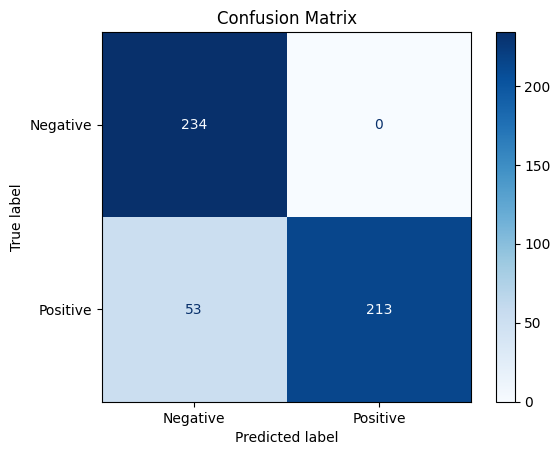

Sonuçlar ve skorlar kaydedildi: test_results_with_scores.csv


In [ ]:
# 4. Test Et
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
FastLanguageModel.for_inference(model)
test_data= test_data.shuffle(seed=42)
test_results = test_model_on_dataset(model, tokenizer, test_data["train"].select(range(500)))


results_df = pd.DataFrame(test_results)


y_true = results_df["true_label"]
y_pred = results_df["predicted_label"]


report = classification_report(y_true, y_pred, target_names=["Negative", "Positive"])
print("Performans Raporu:\n", report)


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


results_df.to_csv("test_results_with_scores.csv", index=False)
print("Sonuçlar ve skorlar kaydedildi: test_results_with_scores.csv")

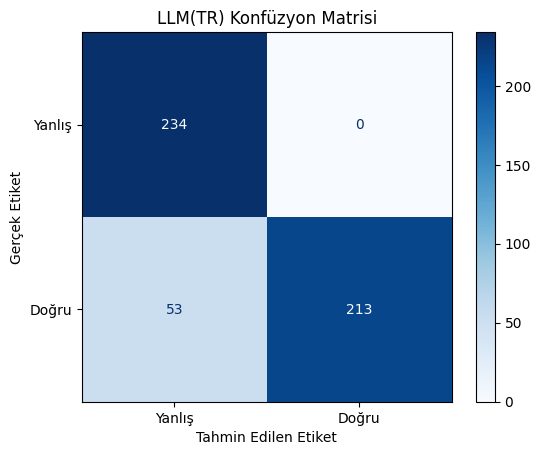

Doğruluk (Accuracy): 0.8940
Kesinlik (Precision): 0.9136
Duyarlılık (Recall): 0.8940
F1 Skoru: 0.8935

Türkçe Detaylı Rapor:

Yanlış:
  Kesinlik (Precision): 0.8153
  Duyarlılık (Recall): 1.0000
  F1 Skoru: 0.8983

Doğru:
  Kesinlik (Precision): 1.0000
  Duyarlılık (Recall): 0.8008
  F1 Skoru: 0.8894

macro avg:
  Kesinlik (Precision): 0.9077
  Duyarlılık (Recall): 0.9004
  F1 Skoru: 0.8938

weighted avg:
  Kesinlik (Precision): 0.9136
  Duyarlılık (Recall): 0.8940
  F1 Skoru: 0.8935


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


class_names = ["Yanlış", "Doğru"]


cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("LLM(TR) Konfüzyon Matrisi")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Kesinlik (Precision): {precision:.4f}")
print(f"Duyarlılık (Recall): {recall:.4f}")
print(f"F1 Skoru: {f1:.4f}")


report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=True)

print("\nTürkçe Detaylı Rapor:")
for class_label, metrics in report.items():
    if isinstance(metrics, dict): 
        print(f"\n{class_label}:")
        print(f"  Kesinlik (Precision): {metrics['precision']:.4f}")
        print(f"  Duyarlılık (Recall): {metrics['recall']:.4f}")
        print(f"  F1 Skoru: {metrics['f1-score']:.4f}")


Osman

In [ ]:
FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    alpaca_prompt.format(
        """**"Mysterious Lights Over Norwegian Sky Spark Scientific Debate"**

Residents of Tromsø, a city in northern Norway, were stunned on Thursday night by the sudden appearance of spiral-shaped lights in the Arctic sky. The phenomenon, visible for several minutes before fading away, has sparked widespread debate among experts and locals alike.

Witnesses described the lights as a glowing spiral that appeared to expand and then gradually disappear. Videos of the event quickly went viral, drawing comparisons to the infamous 2009 Norway spiral, which was later explained as the result of a failed Russian missile test.

“This was unlike anything I’ve seen before,” said Anders Eriksen, an amateur astronomer from Tromsø. “It didn’t behave like natural auroras or meteorological phenomena. It was too symmetrical.”

The Norwegian Meteorological Institute (NMI) has yet to issue an official statement, but some experts have speculated that the event may be linked to a scientific experiment or a rocket launch. The European Space Agency confirmed that no scheduled activity occurred in the region that night, leaving room for further questions.

Adding to the mystery, local power grids experienced minor fluctuations shortly after the lights were reported, though energy officials have not linked this to the event.

“We’re looking into all possible explanations, including natural and man-made causes,” said a spokesperson for the Tromsø Geophysical Observatory.

While some conspiracy theories have emerged on social media, with claims of UFO sightings or secret military tests, scientists urge caution. Dr. Lina Ødegård, an astrophysicist at the University of Oslo, said the phenomenon is likely to have a “mundane” explanation, such as a high-altitude plasma interaction or an experimental rocket test.

The Norwegian government has remained tight-lipped about the event, leading to increased speculation. Locals and scientists alike are eager for answers, with many calling for increased transparency in explaining unusual celestial phenomena.

As investigations continue, Tromsø’s mysterious lights have reignited global interest in the secrets of the Arctic skies, leaving the public to wonder whether this was an extraordinary natural occurrence—or something else entirely.""",# Metin
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
sonuc = tokenizer.batch_decode(outputs)
print((sonuc[0]))
toGetHer = sonuc[0]


<bos>
Sistem:
Sen bir yapay zeka sınıflandırıcısın. Amacın, verilen metinlerin içeriklerini inceleyerek informatik doğruluğunu analiz etmek. Gelen metinlerin doğru bir ifade mi yoksa yanlış bir ifade mi olduğunu belirlemelisin. Değerlendirme yaparken hem dilsel hem de içeriksel tutarlılığı dikkate al.
Metin:
**"Mysterious Lights Over Norwegian Sky Spark Scientific Debate"**  

Residents of Tromsø, a city in northern Norway, were stunned on Thursday night by the sudden appearance of spiral-shaped lights in the Arctic sky. The phenomenon, visible for several minutes before fading away, has sparked widespread debate among experts and locals alike.  

Witnesses described the lights as a glowing spiral that appeared to expand and then gradually disappear. Videos of the event quickly went viral, drawing comparisons to the infamous 2009 Norway spiral, which was later explained as the result of a failed Russian missile test.  

“This was unlike anything I’ve seen before,” said Anders Eriksen, 

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
!pip install together


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0


In [ ]:
from together import Together

client = Together(api_key="")

response = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    messages=[{"role":"user", "content": toGetHer + " Bu haberin cevabının neden böyle olduğunu gerekçelendir."}],
    max_tokens=500,
    temperature=0.7,
    top_p=0.7,
    top_k=50,
    repetition_penalty=1,
    stop=["<|eot_id|>","<|eom_id|>"],
    stream=True
)
for token in response:
    if hasattr(token, 'choices'):
        print(token.choices[0].delta.content, end='', flush=True)

Bu haberin doğruluğunu analiz etmek için hem dilsel hem de içeriksel tutarlılığı dikkate aldım. Haber, Norveç'in Tromsø şehrinde görülen spiral şekilli ışıklarla ilgili bir olayı anlatıyor. Haber, olayın tanıklarının ifadelerine, uzmanların görüşlerine ve olayla ilgili spekülasyonlara yer veriyor.

Haberin dilsel tutarlılığı açısından, haberin dilinin akıcı ve anlaşılır olduğu söylenebilir. Haber, olayı açık ve net bir şekilde anlatıyor ve okuyucunun olayı takip etmesine yardımcı oluyor.

Ancak, haberin içeriksel tutarlılığı açısından bazı sorunlar olduğu söylenebilir. Haber, olayın nedenini ve açıklamasını tam olarak vermemektedir. Haber, bazı uzmanların görüşlerine yer vermesine rağmen, olayın nedenini kesin olarak belirlememektedir. Ayrıca, haberde bazı spekülasyonlar ve komplo teorileri de yer almaktadır.

Bu nedenle, haberin doğruluğunu analiz ettiğimde, haberin bazı eksiklikler ve belirsizlikler içerdiğini gördüm. Haber, olayın nedenini ve açıklamasını tam olarak vermemektedir ve

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Unsloth has 2x faster inference!
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
The next number in the Fibonacci sequence is 13. The sequence continues as follows: 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 4


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()


In [ ]:
# model.save_pretrained("lora_model") # Local saving
# tokenizer.save_pretrained("lora_model")
model.push_to_hub("OsBaran/llm_model1_entr", token = "") # Online saving
tokenizer.push_to_hub("OsBaran/llm_model1_entr", token = "") # Online saving

README.md:   0%|          | 0.00/582 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/216M [00:00<?, ?B/s]

Saved model to https://huggingface.co/OsBaran/llm_model1_entr


  0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

**Now** if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "OsBaran/llm_model1_entr", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Unsloth has 2x faster inference!

# alpaca_prompt = You MUST copy from above!
FastLanguageModel.for_inference(model) # Unsloth has 2x faster inference!
inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64)

==((====))==  Unsloth 2024.12.8: Fast Gemma2 patching. Transformers: 4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/216M [00:00<?, ?B/s]

Unsloth 2024.12.8 patched 42 layers with 42 QKV layers, 42 O layers and 42 MLP layers.


<bos>
Sistem:
Sen bir yapay zeka sınıflandırıcısın. Amacın, verilen metinlerin içeriklerini inceleyerek informatik doğruluğunu analiz etmek. Gelen metinlerin doğru bir ifade mi yoksa yanlış bir ifade mi olduğunu belirlemelisin. Değerlendirme yaparken hem dilsel hem de içeriksel tutarlılığı dikkate al.
Metin:
What is a famous tall tower in Paris?

Cevap:
Yanlış<eos>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)
10. [**NEW**] We make Llama-3 8b, 70b **2x faster**! See our [Llama-3 8b notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>